In [2]:
!pip install pinecone-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 8.1 MB/s eta 0:00:00


In [31]:
!pip install openai scipy matplotlib scikit-learn umap-learn umap
# 출처: https://bcho.tistory.com/1402 [조대협의 블로그:티스토리]

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 8.7 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.9/245.9 kB 16.9 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.8 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached kiwisolver-1.4.5-cp311-cp311-macosx_11_0_arm64.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.7 MB/s eta 0:00:00


In [22]:
import os
from openai import OpenAI
from tqdm.autonotebook import tqdm
from pinecone import Pinecone

In [23]:
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [20]:
pc = Pinecone(
    api_key=os.environ.get("PINECONE_API_KEY")
)
pc.list_indexes()

{'indexes': [{'dimension': 1536,
              'host': 'autorag-0jrtdej.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'autorag',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}

In [57]:
index = pc.Index("autorag")

texts = [
    ("코카콜라", "코카콜라는 까만색이다."),
    ("코카콜라", "코카콜라는 빨간색 캔에 담겨 있다."),
    ("코카콜라", "코카콜라는 탄산음료다."),
    ("팹시", "팹시는 까만색이다."),
    ("팹시", "팹시는 까만색 캔에 담겨 있다."),
    ("팹시", "팹시는 탄산음료다."),
]
embedded_vectors = []
for number, (title, maintext) in enumerate(texts):
    embedding = get_embedding(
        text = maintext,
        model = "text-embedding-ada-002",
    )
    index.upsert(
        vectors=[
            {
                "id": f"{number}", 
                "values": embedding,
                "metadata": {
                    "title":title,
                    "text":maintext
                }
            },
        ],
        namespace= "drink"
    )    
    embedded_vectors.append(
        {
            "number": number,
            "embedded_text": [embedding],
            "title": title,
            "text": maintext,    
        }
    )
len(embedded_vectors)

6

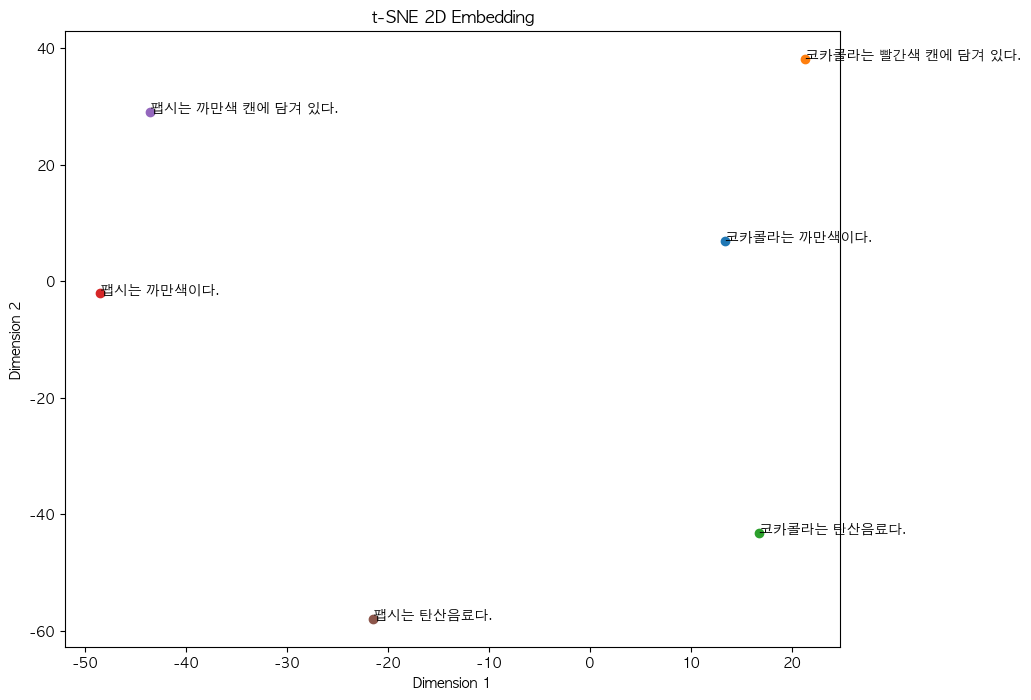

In [66]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

df = pd.concat([pd.DataFrame(k) for k in embedded_vectors]).reset_index(drop=True)
perplexity_value = 3 # min(5, len(df))
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
embedding_2d = tsne.fit_transform(np.array(list(df['embedded_text'])))

# Add the 2D embedding to the DataFrame
df['embedding_2d'] = list(embedding_2d)

# Plot the 2D embedding
plt.figure(figsize=(10, 8))
for i in range(len(df)):
    plt.scatter(embedding_2d[i, 0], embedding_2d[i, 1])
    plt.text(embedding_2d[i, 0], embedding_2d[i, 1], df['text'][i][:20])

plt.title('t-SNE 2D Embedding')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [72]:
index.query(
    namespace="drink",
    vector=get_embedding(
        text = "코카콜라는 무슨 색인가요?",
        model = "text-embedding-ada-002",
    ),
    top_k=2,
    include_values=True,
    include_metadata=True,
)["matches"][0]["metadata"]

{'text': '코카콜라는 까만색이다.', 'title': '코카콜라'}